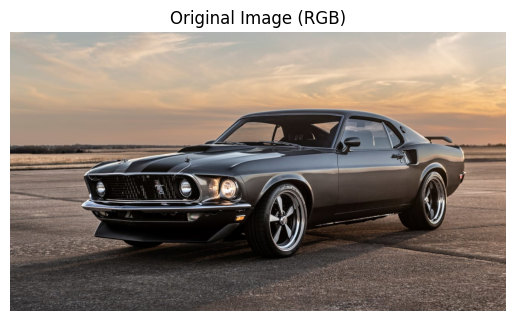

Image Dimensions: 1260x710
Total Pixels: 894600


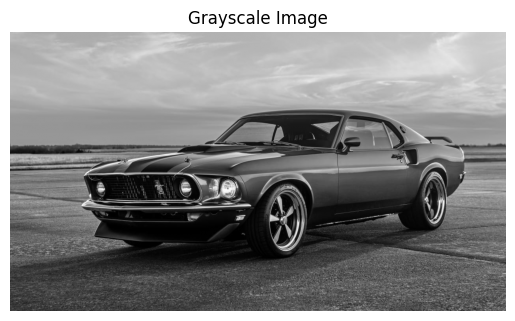

Black Pixel Count: 476151


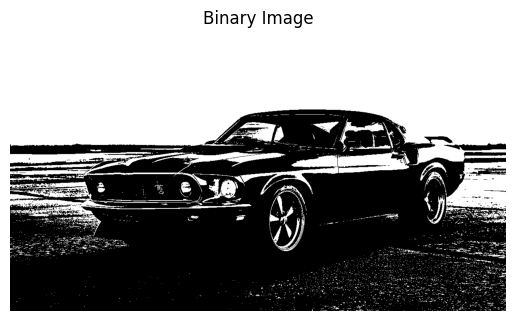

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt


image_bgr = cv2.imread("/content/Ford Mustang Mach 1-5.jpg")

image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

plt.imshow(image_rgb)
plt.title("Original Image (RGB)")
plt.axis("off")
plt.show()

height, width, channels = image_rgb.shape
total_pixels = height * width
print(f"Image Dimensions: {width}x{height}")
print(f"Total Pixels: {total_pixels}")

image_gray = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2GRAY)
cv2.imwrite("image_gray.jpg", image_gray)  # Save grayscale image

plt.imshow(image_gray, cmap="gray")
plt.title("Grayscale Image")
plt.axis("off")
plt.show()

_, image_binary = cv2.threshold(image_gray, 128, 255, cv2.THRESH_BINARY)
cv2.imwrite("image_binary.jpg", image_binary)  # Save binary image

black_pixels = np.sum(image_binary == 0)
print(f"Black Pixel Count: {black_pixels}")

plt.imshow(image_binary, cmap="gray")
plt.title("Binary Image")
plt.axis("off")
plt.show()

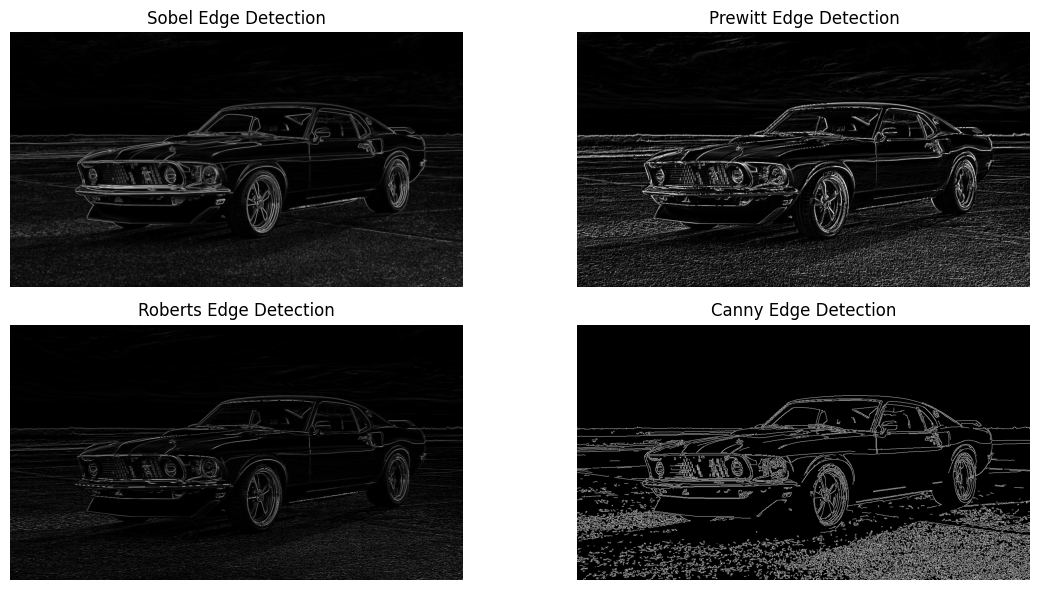

In [4]:
# Sobel Operator
sobel_x = cv2.Sobel(image_gray, cv2.CV_64F, 1, 0, ksize=3)
sobel_y = cv2.Sobel(image_gray, cv2.CV_64F, 0, 1, ksize=3)
sobel_combined = cv2.magnitude(sobel_x, sobel_y)

# Prewitt Operator
prewitt_x = cv2.filter2D(image_gray, -1, np.array([[1, 0, -1], [1, 0, -1], [1, 0, -1]]))
prewitt_y = cv2.filter2D(image_gray, -1, np.array([[1, 1, 1], [0, 0, 0], [-1, -1, -1]]))
prewitt_combined = prewitt_x + prewitt_y

# Roberts Cross Operator
roberts_x = np.array([[1, 0], [0, -1]], dtype=np.float32)
roberts_y = np.array([[0, 1], [-1, 0]], dtype=np.float32)
roberts_x_result = cv2.filter2D(image_gray, -1, roberts_x)
roberts_y_result = cv2.filter2D(image_gray, -1, roberts_y)
roberts_combined = roberts_x_result + roberts_y_result

# Canny Edge Detection
canny_edges = cv2.Canny(image_gray, 100, 200)

# Display Edge Detection Results
edges = [sobel_combined, prewitt_combined, roberts_combined, canny_edges]
titles = ["Sobel", "Prewitt", "Roberts", "Canny"]

plt.figure(figsize=(12, 6))
for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.imshow(edges[i], cmap="gray")
    plt.title(f"{titles[i]} Edge Detection")
    plt.axis("off")
plt.tight_layout()
plt.show()


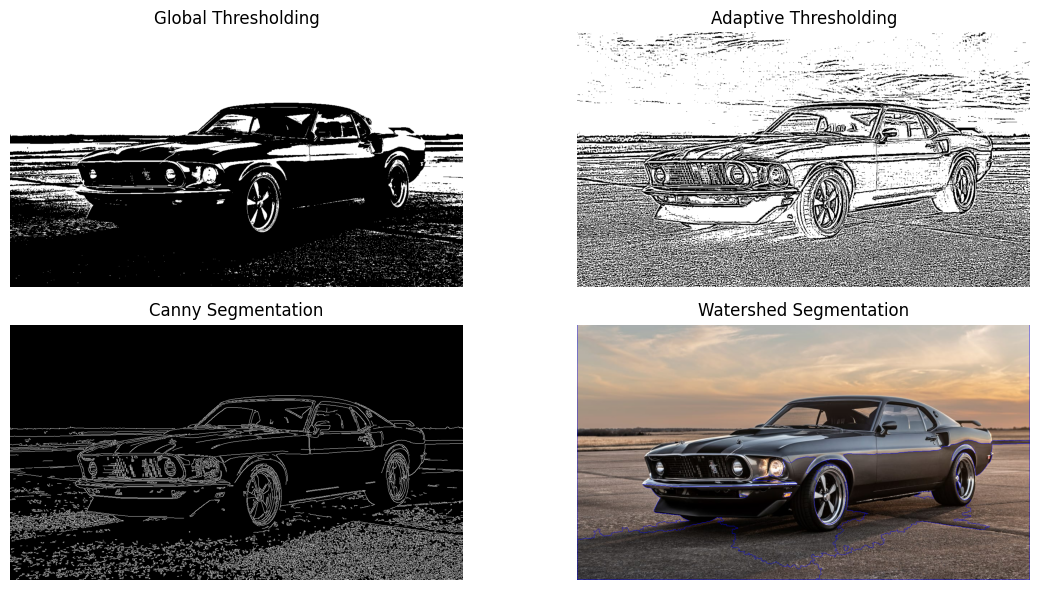

In [5]:
# 1. Global Thresholding
_, global_thresh = cv2.threshold(image_gray, 128, 255, cv2.THRESH_BINARY)

# 2. Adaptive Thresholding
adaptive_thresh = cv2.adaptiveThreshold(image_gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)

# 3. Edge Detection-Based Segmentation (Using Canny)
canny_segmented = cv2.Canny(image_gray, 100, 200)

# 4. Region-Based Segmentation (Watershed Algorithm)
# Convert to grayscale and apply Otsu's threshold
ret, thresh = cv2.threshold(image_gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

# Remove noise
kernel = np.ones((3, 3), np.uint8)
opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)

# Find sure background area
sure_bg = cv2.dilate(opening, kernel, iterations=3)

# Find sure foreground area
dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
ret, sure_fg = cv2.threshold(dist_transform, 0.7 * dist_transform.max(), 255, 0)

# Find unknown region
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg, sure_fg)

# Label markers
ret, markers = cv2.connectedComponents(sure_fg)
markers = markers + 1
markers[unknown == 255] = 0

# Apply Watershed Algorithm
image_bgr_copy = image_bgr.copy()
markers = cv2.watershed(image_bgr_copy, markers)
image_bgr_copy[markers == -1] = [255, 0, 0]  # Mark boundaries in red

# Display segmentation results
segmentation_methods = [global_thresh, adaptive_thresh, canny_segmented, image_bgr_copy]
segmentation_titles = ["Global Thresholding", "Adaptive Thresholding", "Canny Segmentation", "Watershed Segmentation"]

plt.figure(figsize=(12, 6))
for i in range(4):
    plt.subplot(2, 2, i+1)
    if i == 3:  # Show watershed in RGB
        plt.imshow(cv2.cvtColor(segmentation_methods[i], cv2.COLOR_BGR2RGB))
    else:
        plt.imshow(segmentation_methods[i], cmap="gray")
    plt.title(segmentation_titles[i])
    plt.axis("off")
plt.tight_layout()
plt.show()